# Group Assignment NLP course 2024/2025

## Group: NLP Processors
* Ginefra Paolo
* Onori Ferdinando
* Missana Martina
* Uhrich Robin

##  Dataset: [Strategic Game Chess](https://huggingface.co/datasets/laion/strategic_game_chess)

The dataset used contains data on chess games generated through self-play **Stockfish** engine using **Fugaku** (a supercomputer in Kobe, Japan) adding initial moves to expand the diversity. It contains **3.2 billion games** with approximately 608 billion moves.

Due to computational constraints we decided to work just on the first parquet file of the dataset, containing the first **100.000 games**. 

Each game in the dataset is composed of three columns:
* **Move**: a sequence of all the moves in [UCI notation](https://en.wikipedia.org/wiki/Universal_Chess_Interface) made during the game.

* **Termination**: the condition under which the game ended. Possible values include: 
    - `CHECKMATE`
    - `INSUFFICIENT MATERIAL`
    - `FIVEFOLD_REPETITION`
    - `SEVENTYFIVE_MOVES`
    - `STALEMATE`
* **Result**: result of the game
    - `1-0`         (White wins)
    - `1/2-1/2`     (Draw)
    - `0-1`         (Black wins)

 #### **Data Wrangling**

To facilitate the use of the dataset and to ensure that all necessary information is available for the project, a dataset was created with the following structure:


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from nlpChess.utils.DatasetLoader import loadConcatenatedDataset
ds = loadConcatenatedDataset()
df = ds.to_pandas()

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 10 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Moves              100000 non-null  object
 1   Termination        100000 non-null  object
 2   Result             100000 non-null  object
 3   pieces             100000 non-null  object
 4   captures           100000 non-null  object
 5   checks             100000 non-null  object
 6   next_moves         100000 non-null  object
 7   termination_seqs   100000 non-null  object
 8   result_seqs        100000 non-null  object
 9   __index_level_0__  100000 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 7.6+ MB


where 

| **Feature**       | **Description**                                                                 |
|-------------------|---------------------------------------------------------------------------------|
| **Moves**         | The sequence of moves in UCI format played in the game.                                       |
| **Termination**   | How the game ended (e.g., checkmate).                     |
| **Result**        | The final result of the game (e.g., 1-0, 0-1, 1/2-1/2).                          |
| **Pieces**        | The piece moved in every move.                                                  |
| **Captures**      | The type of piece captured (if any) at each move.                               |
| **Checks**        | A boolean indicating whether a move resulted in a check (`true` or `false`).    |
| **Next_move**     | The move sequence shifted by one position, useful for predictive modeling.      |
| **Result_seqs**   | A repeated sequence of the final result, aligned with the length of the moves.  |

From the package it's possible to 

* load the whole the dataset for analysis 
* load the dataset divided in **train**, **validation**  and **test** (used for models)

In addition, two YAML files were created to support data processing:

- **Move Lookup Table**  

  A mapping of all possible moves to unique integer identifiers.

- **Result Lookup Table**  

  A mapping of game results (`1-0`, `0-1`, `1/2-1/2`) to numerical labels, useful for classification tasks.


All the data used is uploaded on [**Hugging Face**](https://huggingface.co/collections/ruhrpott/nlp-chess-68319e986521d0f91dc66e4f)

The objective of this project is to explore the chess dataset and investigate how natural language processing techniques can be adapted to understand and model the structured language of chess.

We are trying to identify which methods successfully capture the patterns and semantics of chess notation, and which approaches fall short when applied to this domain.

#### TODOs:

* disclaimer that we stick the dataset as closely as possible with assumingnot  having knowledge ofunderlyingmodelof chess

### 1. Preliminary Analysis

#### TODOs:
* Data Exploration (type of data, structure, vocaboulary, ...) - verbose stuff
* graph - verbose stuff
* usage of move visualizer/ move plotter
* clustering (Australia  plot) (Paolo explaining if  clusters make sens)
* word2vec and embeddings (Paolo)
* skipgrams n-grams(matrices, dendrograms(?))

### 2. Training Models

#### TODOs:
* LAMA
* LSTM
* RAG (Paolo)
* Transformer (plots)
* Zeroshot-multishot(?)(Ferdinando)


### 3. Possible Extensions

#### TODOs:
* chessbots with game entropy etc. (lstm,ferdinando,voice)

(menu and intuition)

### 4. Conclusions (?)

* adding knowledge should result in better performances...
* computationalconstraintsssss
* chess grammar

## How is the dataset structured ?
#### And how stockfish play?

We use dataset loaded in the Data Wrankling

Look the the Result and Termination cause across all the games.
By rules all the termination not CHECKMATE lead to draw

Text(0.5, 1.0, 'Result')

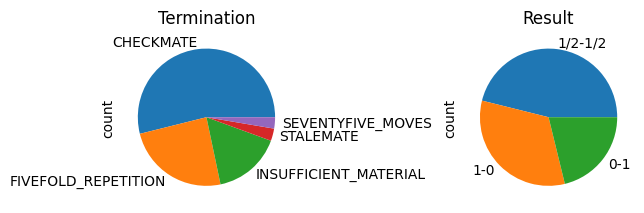

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
df["Termination"].value_counts().plot.pie(ax=ax1)
df["Result"].value_counts().plot.pie(ax=ax2)
fig.tight_layout()

ax1.set_title("Termination")
ax2.set_title("Result")

Within the CHECKMATE the distribution is around around 33% for "1-0" and around 21% for "0-1" while the tie are around 46%

_"According to chess analyst Jeff Sonas, although an upward draw rate trend can be observed in general master-level play since the beginning of the 20th century, it is currently "holding pretty steady around 50%, and is only increasing at a very slow rate". The draw rate of elite grandmasters, rated more than 2750 Elo, is, however, significantly higher, surpassing 70% in 2017 and 2018."_

Wikipedia

Which let us think the stockfish model which generate those games wasn't the top version cause it is estimate to have an 3500 Elo, if that was the case we would expect a higher tie rate

Let's have a look at the Termination distribution across the different game lenght

Text(0, 0.5, 'Number of Games')

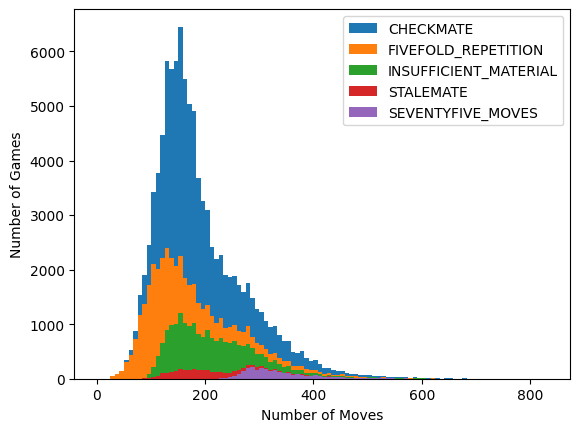

In [5]:
lengths = df.copy()
lengths["Moves"] = df["Moves"].apply(lambda x: len(x)) 

fig, ax = plt.subplots()            

bins = np.linspace(0, max(lengths["Moves"]), 100 + 1)
bin_width = bins[1]
counts = []
labels = []
n_labels = len(lengths["Termination"].unique())
bar_width = bin_width / n_labels
for idx, (label, group) in enumerate(lengths.groupby("Termination")):
    count, _ = np.histogram(group["Moves"], bins=bins)
    counts.append(count)
    labels.append(label)                    
    #   ax.bar(bins[:-1] + bar_width / 2 + idx * bar_width, count, bar_width)
counts = np.stack(counts)
sort_idx = np.argsort(counts.sum(axis=1))
counts = counts[sort_idx]
labels = np.array(labels)[sort_idx]

for count, label in zip(counts.cumsum(axis=0)[::-1], labels[::-1]):
    ax.bar(bins[:-1] + bin_width / 2, count, width=bin_width, label=label)
    
ax.legend()
ax.set_xlabel("Number of Moves")
ax.set_ylabel("Number of Games")

Already the peak of the distribution is over the mean number of moves in a human chess game, which usually end before 80 moves.

Probably during the match if not major error are commited by one of the two bot and then punished by the other in the phase were there're more strategy possibilities, otherwise the model playing nearly at the same level end up in a type of stall which lead to a tie.

We have a brief look at the pawn promotion/capture distribution
In the UCI format:

* k: king
* q: queen
* r: rook
* b: bishop
* n: knight
* p: pawn

<Axes: >

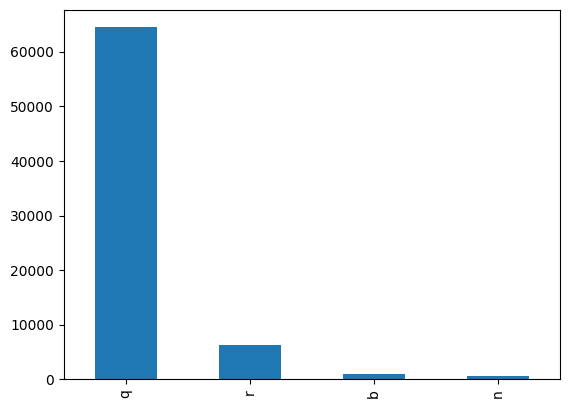

In [7]:
start_pos = np.zeros((8, 8), dtype=int)
end_pos = np.zeros((8, 8), dtype=int)
captured_pieces = []
pieces = "kqbnrp"
capture_pos = np.zeros((len(pieces), 8, 8), dtype=int)

all_moves = np.concatenate(df["Moves"].values)
for move in all_moves:
    start_pos[ord(move[0]) - ord("a"), int(move[1]) - 1] += 1
    end_pos[ord(move[2]) - ord("a"), int(move[3]) - 1] += 1
        
    if len(move) == 5:
        captured_pieces.append(move[4])
        capture_pos[pieces.find(move[4]), ord(move[2]) - ord("a"), int(move[3]) - 1] += 1

pd.Series(captured_pieces).value_counts().plot.bar()        

As expected the queen is largely the most promoted piece, pleasing some chess metrics as the queen is the piece with highest value, nonetheless it is also probabibly considered the most relevant strategic piece by Stockfish

We know the additional starting moves were added manually in order to add some variability, we look now which type of moves has been added: if nearly random or standard openings moves

100%|██████████| 100000/100000 [00:00<00:00, 612493.14it/s]


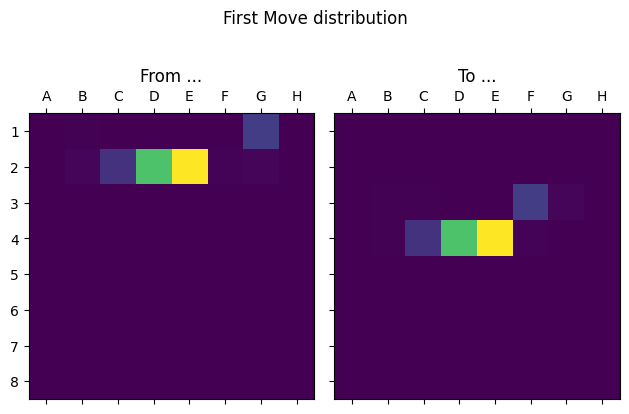

In [8]:
start_pos = np.zeros((8, 8), dtype=int)
end_pos = np.zeros((8, 8), dtype=int)
captured_pieces = []
pieces = "kqbnrp"
capture_pos = np.zeros((len(pieces), 8, 8), dtype=int)
for move in tqdm(df["Moves"]):
    move = move[0]
    start_pos[ord(move[0]) - ord("a"), int(move[1]) - 1] += 1
    end_pos[ord(move[2]) - ord("a"), int(move[3]) - 1] += 1
        
    if len(move) == 5:
        captured_pieces.append(move[4])
        capture_pos[pieces.find(move[4]), ord(move[2]) - ord("a"), int(move[3]) - 1] += 1



fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.matshow(start_pos.T)
ax2.matshow(end_pos.T)

fig.suptitle("First Move distribution")
ax1.set_title("From ...")   
ax2.set_title("To ...")

ax1.set_yticks(np.arange(8), np.arange(8) + 1)
ax1.set_xticks(np.arange(8), ["A", "B", "C", "D", "E", "F", "G", "H"])
ax2.set_xticks(np.arange(8), ["A", "B", "C", "D", "E", "F", "G", "H"])
fig.tight_layout()

Logically 4 moves can be recreated from this distribution

Most frequent first moves: ['e2e4', 'd2d4', 'g1f3', 'c2c4']


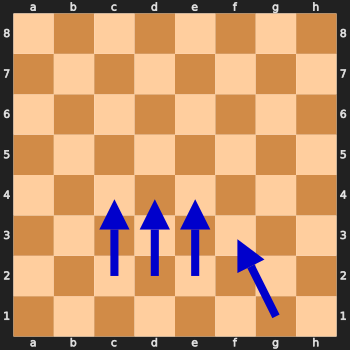

In [59]:
from nlpChess.utils.MovePlotter import MovePlotter

openings = ["e2e4","d2d4","g1f3","c2c4"]
print("Most frequent first moves:", openings)

plotter = MovePlotter(f"Most frequent first moves {openings}")
for move in openings:
    plotter.addMove(move)
    
plotter.plot(justBoard=True)

## How are the piece moved distributed across the games?

To answer this question, let's do some statistical analysis on the pieces moved

Load the dataset

In [10]:
import chess
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from collections import Counter
from datasets import load_dataset
import tqdm
import seaborn as sns
sns.set_theme()

%load_ext autoreload
%autoreload 2

In [2]:
from nlpChess.utils.DatasetLoader import loadConcatenatedDataset
ds = loadConcatenatedDataset()
df = ds.to_pandas()

Let's create new columns containing the sequence of pieces moved in each phase of the game.

In [4]:
len_games = df['Moves'].apply(len)
openingLimit = len_games*0.1
midgameLimit = len_games*0.3
endgameLimit = len_games.apply(lambda x:max(x, 31))

In [5]:
df['Opening'] = df.apply(lambda row: row['pieces'][:int(openingLimit.loc[row.name])], axis=1)
df['Midgame'] = df.apply(lambda row: row['pieces'][int(openingLimit.loc[row.name]):int(midgameLimit.loc[row.name])], axis=1)
df['Endgame'] = df.apply(lambda row: row['pieces'][int(midgameLimit.loc[row.name]):int(endgameLimit.loc[row.name])], axis=1)

To start the analysis it is computed the average move distribution per piece across all games

In [8]:
pieces = df['pieces']
# Concatenate all pieces from all games into a single list
all_pieces = np.concatenate(pieces.values)

In [11]:
# count the number of pieces and relative frequencies
piece_counts = Counter(all_pieces)
piece_counts = dict(piece_counts)
piece_counts = {k: v for k, v in sorted(piece_counts.items(), key=lambda item: item[1], reverse=True)}
# Create a DataFrame from the piece counts
piece_counts_df = pd.DataFrame.from_dict(piece_counts, orient='index', columns=['count'])
piece_counts_df['relative_frequency'] = piece_counts_df['count'] / piece_counts_df['count'].sum()
piece_counts_df 

,count,relative_frequency
k,5066635,0.267344
r,4202215,0.221732
p,3034835,0.160135
b,2699589,0.142445
n,2153684,0.113640
q,1794775,0.094702


Plot the average move distribution per piece across all games

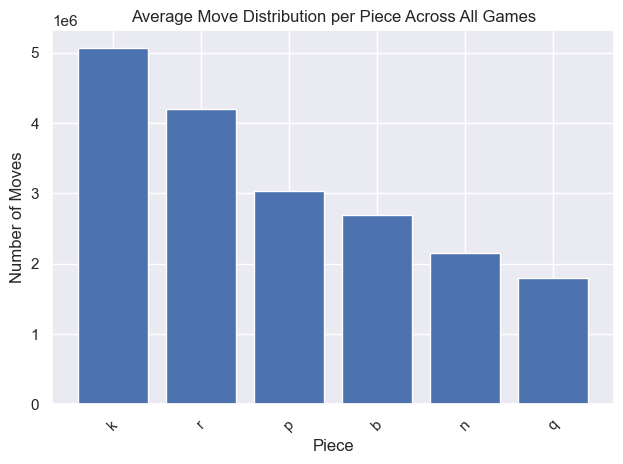

In [12]:
plt.bar(piece_counts_df.index, piece_counts_df['count'])
plt.title("Average Move Distribution per Piece Across All Games")
plt.xlabel("Piece")
plt.ylabel("Number of Moves")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

From the plot it is evident that the most moved piece is the king, and since the king is not used in the early part of games, it can be assumed that our games have a long ending phase.

Let's apply the same analysis to the pieces moved but divided by phase of the game to see if Stockfish uses  different pieces in different phases .

In [13]:
opening_pieces = np.concatenate(df['Opening'].values)
midgame_pieces = np.concatenate(df['Midgame'].values)
endgame_pieces = np.concatenate(df['Endgame'].values)

In [14]:
def piece_distribution(pieces_array):
    counts = Counter(pieces_array)
    counts = dict(sorted(counts.items(), key=lambda item: item[1], reverse=True))
    df_counts = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
    df_counts['relative_frequency'] = df_counts['count'] / df_counts['count'].sum()
    return df_counts

opening_piece_counts_df = piece_distribution(opening_pieces)
midgame_piece_counts_df = piece_distribution(midgame_pieces)
endgame_piece_counts_df = piece_distribution(endgame_pieces)

print("Opening:\n", opening_piece_counts_df)
print("\nMidgame:\n", midgame_piece_counts_df)
print("\nEndgame:\n", endgame_piece_counts_df)

Opening:
     count  relative_frequency
p  839313            0.453768
n  464192            0.250962
b  307876            0.166451
q  101961            0.055124
k   89141            0.048193
r   47170            0.025502

Midgame:
     count  relative_frequency
p  884560            0.233380
r  723732            0.190947
b  701864            0.185178
n  642586            0.169538
q  465006            0.122686
k  372467            0.098271

Endgame:
      count  relative_frequency
k  4605027            0.345934
r  3431313            0.257764
b  1689849            0.126943
p  1310962            0.098481
q  1227808            0.092234
n  1046906            0.078645


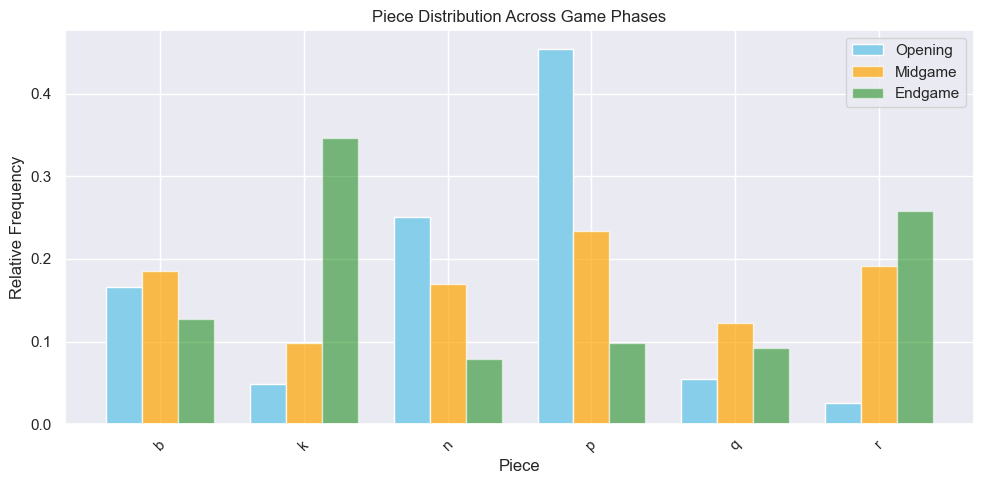

In [15]:
all_pieces = sorted(set(opening_piece_counts_df.index) | set(midgame_piece_counts_df.index) | set(endgame_piece_counts_df.index))

opening_freqs = [opening_piece_counts_df['relative_frequency'].get(piece, 0) for piece in all_pieces]
midgame_freqs = [midgame_piece_counts_df['relative_frequency'].get(piece, 0) for piece in all_pieces]
endgame_freqs = [endgame_piece_counts_df['relative_frequency'].get(piece, 0) for piece in all_pieces]

x = np.arange(len(all_pieces))
width = 0.25

plt.figure(figsize=(10, 5))
plt.bar(x - width, opening_freqs, width, label='Opening', color='skyblue')
plt.bar(x, midgame_freqs, width, label='Midgame', color='orange', alpha=0.7)
plt.bar(x + width, endgame_freqs, width, label='Endgame', color='green', alpha=0.5)
plt.title("Piece Distribution Across Game Phases")
plt.xlabel("Piece")
plt.ylabel("Relative Frequency")
plt.xticks(x, all_pieces, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


From the plot, the relative frequency suggests that:

* Pawns are the most used pieces in the early phase of the game.

* The king is the most moved piece in the endgame.

This aligns with standard chess strategy, making it a meaningful result.

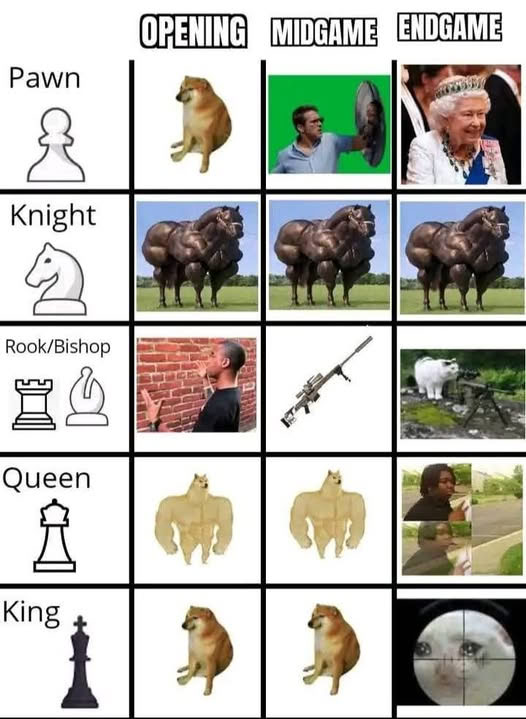

Let's now plot a heatmap that, for each move number, highlights the count of pieces moved by type.

In [16]:
# dataframe with the index+1 of every piece in df['pieces']
def get_piece_indices(pieces):
    piece_indices = []
    for piece in pieces:
        indices = [i + 1 for i, p in enumerate(piece) if p != '0']
        piece_indices.append(indices)
    return piece_indices
df['piece_indices'] = get_piece_indices(df['pieces'])

In [17]:
# put together df['piece_indices'] and df['pieces'] in a new dataframe
piece_indices_df = pd.DataFrame({
    'piece_indices': df['piece_indices'].explode(),
    'pieces': df['pieces'].explode()
})

In [18]:
#group by  move_number and piece
df_count = piece_indices_df.groupby(['piece_indices', 'pieces']).size().reset_index(name='count')

Once created the dataframe containing all the information needed let's plot the heatmap.

In [20]:
#normalize  by  move_number
df_count['normalized_count'] = df_count['count'] / df_count.groupby('piece_indices')['count'].transform('sum')

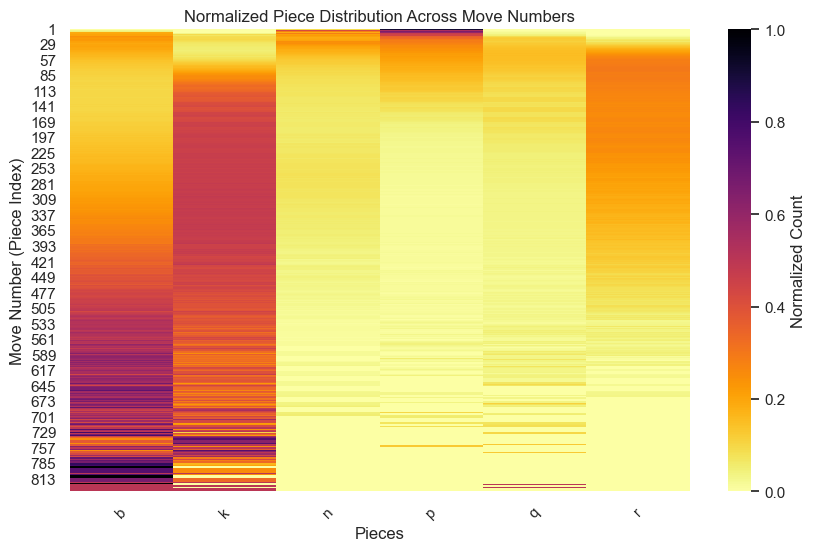

In [21]:
#heatmap of the normalized counts
pivot_table = df_count.pivot(index='piece_indices', columns='pieces', values='normalized_count').fillna(0)
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, cmap='inferno_r', fmt='.2f', cbar_kws={'label': 'Normalized Count'})
plt.title("Normalized Piece Distribution Across Move Numbers")
plt.xlabel("Pieces")
plt.ylabel("Move Number (Piece Index)")
plt.xticks(rotation=45)
plt.show()

From the heatmap it is possible to see the opening phase (with the pawns being the most moved pieces), and than the ending phase, played almost entirely by bishops and king.

It is also worth noting that the game are very long with respect to a normal chess game (due to the fact that they are played by Stockfish).

## How much is move language of chess related to a Natural Language?

In order to answer this question the idea was to apply the Zipf`s Law to the dataset trying to compare it with a classic Natural Language such as english language.

#### Zipf's Law

The comparison was made between the chess dataset and a dataset containing the plays of Shakespear (with the assumption of Shakespear as a good representation of english language), to understand if the sequence of moves in chess could be identified as Natural Language.

The Zipf`s Law is defined as: 

$f(r) = \frac{C}{r^s}$

where f(r) is the frequency of the word at rank r, C is a constant, and s is the Zipf`s exponent.

The Zipf's exponent is useful to answer the question proposed since:

- if **s<1**: The distribution flattens. Frequencies are more evenly spread across ranks, indicating a more uniform distribution of items.
- if **s=1**: The classic Zipfian case. The second-ranked item occurs half as frequently as the first, and so on. This implies that a few words are extremely common, and many are rare. The classic natural languages are usually Zipfian.
- if **s>1**: The distribution is steeper.
    High-ranked items dominate, and lower-ranked items become significantly rare. 
    This suggests a system where a few elements are overwhelmingly prevalent.

The exponent can be computed by finding ranks and sequences of the tokens and estimating the exponent from their plot.

Source for Zipf's Law exponent for natural languages: [here](https://www.sciencedirect.com/science/article/pii/S0375960117305388)

In [43]:
import chess
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import pandas as pd
from collections import Counter
from datasets import load_dataset
import tqdm
import seaborn as sns
sns.set_theme()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the dataset

In [22]:
from nlpChess.utils.DatasetLoader import loadConcatenatedDataset
ds = loadConcatenatedDataset()
df = ds.to_pandas()

Let's remove the fifth character from the tokens since the castle is not important for our task since we just look at the moves on the checkboard

In [23]:
def removeFifthChar(string):
    if len(string) < 5:
        return string
    return string[:4]

#Apply the function to the 'moves' column
df['moves'] = df['Moves'].apply(removeFifthChar)

Let's create a move list containing the moves of all the games.

In [24]:
# Get all the performed moves
# Concatenate all moves from all games into a single list
moves = [move for game in df['Moves'] for move in game]

It is possible now to count the occurences of each move and sort the results by frequency to see if Zipf's law is applied.

In [25]:
# Count the occurrences of each move
move_counts = Counter(moves)

# Sort the moves by frequency
sorted_move_counts = move_counts.most_common()
move_ranks = range(1, len(sorted_move_counts) + 1)
move_frequencies = [count for fen, count in sorted_move_counts]

Let's plot the result. Since the scale is logarithmic for both axes, if the language has an exponent close to one the plot should almost be a line with slope of -1

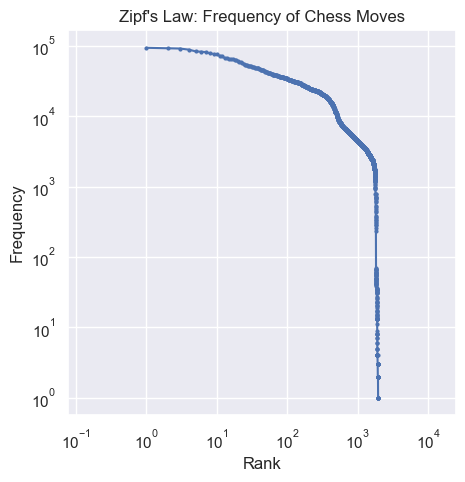

In [26]:
plt.figure(figsize=(5, 5))
plt.loglog(move_ranks, move_frequencies, marker='o', markersize=2)
plt.title("Zipf's Law: Frequency of Chess Moves")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.axis('equal') 
plt.show()

Now it is possiblet to try estimating the Zipf's exponent for this dataset

In [27]:
log_move_ranks = np.log(move_ranks)
log_move_freqs = np.log(move_frequencies)
move_coeffs = np.polyfit(log_move_ranks, log_move_freqs, 1)
move_slope = move_coeffs[0]
print(f"Estimated Zipf exponent for moves: {abs(move_slope):.2f}")

Estimated Zipf exponent for moves: 1.28


From the previous code it is possible to see that the chess language of our dataset has a Zipf`s exponent of **1.28**, pretty close to the Zipfian case, but the shape of the plot is not very close to the Zipfian case.
The exponent could be a sign of it being a Natural Language but the big nonlinearity could be causing a bias in the exponent computation

Let's do some more analysis taking into account the Shakespear data

In [28]:
from nlpChess.utils.DatasetLoader import loadConcatenatedShakespeareDataset
dsShakespeare = loadConcatenatedShakespeareDataset()
dfShakespeare = dsShakespeare.to_pandas()
dfShakespeare.head()

,Unnamed: 0,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,19217,19218,Antony and Cleopatra,9.0,2.1.33,POMPEY,"How now, Varrius!"
1,99413,99414,Troilus and Cressida,32.0,1.2.66,CRESSIDA,"Ay, if I ever saw him before and knew him."
2,104667,104668,Twelfth Night,86.0,3.4.193,VIOLA,With the same 'havior that your passion bears
3,41989,41990,Henry VIII,41.0,3.2.121,SUFFOLK,"May be, he hears the king"
4,36553,36554,Hamlet,119.0,5.2.312,HAMLET,"Nay, come, again."


Join the lines of the plays together and tokenize the lines into words.

In [29]:
lines = dfShakespeare['PlayerLine'].tolist()
lines = ' '.join(lines)
lines[:100]
shakespearWritings = lines.split()

Application of the Zipf's Law, plot and estimation of the exponent.

In [30]:
word_counts = Counter(shakespearWritings)
# Sort the words by frequency
sorted_word_counts = word_counts.most_common()
word_ranks = range(1, len(sorted_word_counts) + 1)
word_frequencies = [count for word, count in sorted_word_counts]


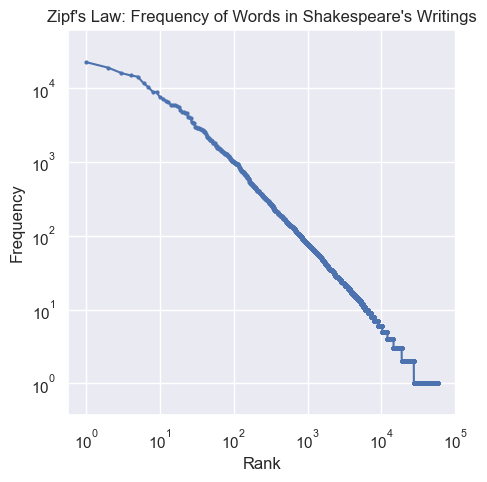

In [31]:
plt.figure(figsize=(5, 5))
plt.loglog(word_ranks, word_frequencies, marker='o', markersize=2)
plt.title("Zipf's Law: Frequency of Words in Shakespeare's Writings")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.axis('equal')
plt.show()

In [32]:
log_word_ranks = np.log(word_ranks)
log_word_freqs = np.log(word_frequencies)
word_coeffs = np.polyfit(log_word_ranks, log_word_freqs, 1)
word_slope = word_coeffs[0]
print(f"Estimated Zipf exponent in Shakespear's writings: {abs(word_slope):.2f}")

Estimated Zipf exponent in Shakespear's writings: 1.14


From these results it is possible to see that also this exponent is close to the Zipfian case, but in this plot we can easily see that the data almost form a precise line with slope -1.

The difference between the two languages is pretty visible in the following plot.

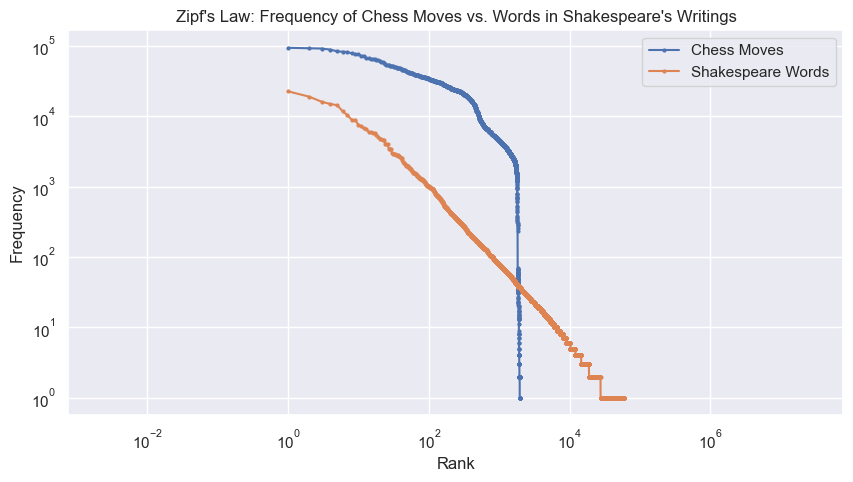

In [33]:
#Compare on the same plot the chess plot and the Shakespear one
plt.figure(figsize=(10, 5))
plt.loglog(move_ranks, move_frequencies, marker='o', label="Chess Moves", markersize=2)
plt.loglog(word_ranks, word_frequencies, marker='o', label="Shakespeare Words", markersize=2)
plt.title("Zipf's Law: Frequency of Chess Moves vs. Words in Shakespeare's Writings")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.axis('equal')
plt.show()

Now it is possible to analyze if the phase of the game in which the move is performed is important in terms of Zipf's Law. 

Is there a game phase where the language is similar to a Natural Language?

The games were divided into three phases:
* **Opening**: 10% of the moves, since the openings are often few and very used, it is expected for the Zipf's exponent to be high.

* **Midgame**: from 10% to 30% of the moves. Since the dataset has very long games with very long final phases, 30% should be a     good representation of midgame. 

* **Endgame**: from 30% to 100%

In [34]:
len_games = df['Moves'].apply(len)
openingLimit = len_games*0.1
midgameLimit = len_games*0.3
endgameLimit = len_games.apply(lambda x:max(x, 31))

In [36]:
df['Opening'] = df.apply(lambda row: row['Moves'][:int(openingLimit.loc[row.name])], axis=1)
df['Midgame'] = df.apply(lambda row: row['Moves'][int(openingLimit.loc[row.name]):int(midgameLimit.loc[row.name])], axis=1)
df['Endgame'] = df.apply(lambda row: row['Moves'][int(midgameLimit.loc[row.name]):int(endgameLimit.loc[row.name])], axis=1)

Let's plot the Zipf's Law for every phase of the game.

In [37]:
all_opening_moves = np.concatenate(df['Opening'].values)
all_midgame_moves = np.concatenate(df['Midgame'].values)
all_endgame_moves = np.concatenate(df['Endgame'].values)

In [38]:
def zipf_plot(move_list, phase_name):
    counter = Counter(move_list)
    frequencies = np.array(sorted(counter.values(), reverse=True))
    ranks = np.arange(1, len(frequencies) + 1)

    plt.plot(np.log(ranks), np.log(frequencies), label=phase_name)
    
    coeffs = np.polyfit(np.log(ranks), np.log(frequencies), 1)
    print(f"{phase_name.capitalize()} Zipf exponent: {-coeffs[0]:.2f}")

Opening Zipf exponent: 2.16
Midgame Zipf exponent: 1.44
Endgame Zipf exponent: 1.18


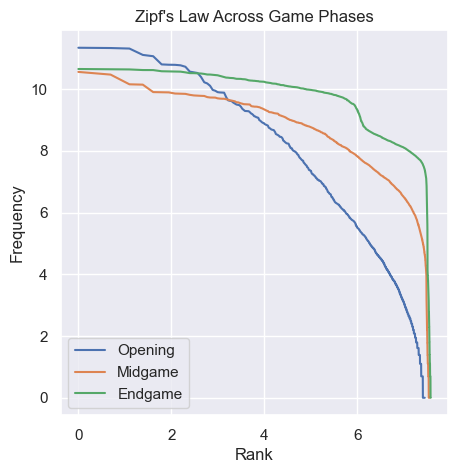

In [39]:
plt.figure(figsize=(5, 5))

zipf_plot(all_opening_moves, "Opening")
zipf_plot(all_midgame_moves, "Midgame")
zipf_plot(all_endgame_moves, "Endgame")

plt.title("Zipf's Law Across Game Phases")
plt.xlabel("Rank")
plt.ylabel("Frequency")
plt.legend()
plt.show()

As expected the exponent for the opening phase is higher than the other two, but from the plot we can see that none of the curves resemble a straight line so no phase is actually similar to a natural language.

As a last analysis it is computed the exponent for every move up to a number of moves (Zipf's exponent for the first N moves of all games) and see if any slice of the move language is close to a natural language.

In [40]:
def computeZipfExponentPerMoveNumber(df, move_number):
    moves = df['Moves'].apply(lambda x: x[move_number-1] if len(x) >= move_number else None)
    moves = moves.dropna()
    move_counts = Counter(moves)
    sorted_move_counts = move_counts.most_common()
    move_ranks = range(1, len(sorted_move_counts) + 1)
    move_frequencies = [count for move, count in sorted_move_counts]
    log_move_ranks = np.log(move_ranks)
    log_move_freqs = np.log(move_frequencies)
    move_coeffs = np.polyfit(log_move_ranks, log_move_freqs, 1)
    move_slope = move_coeffs[0]
    return abs(move_slope)

maxLegths = max(len_games)
zipf_exponents = []
for move_number in tqdm.tqdm(range(1, maxLegths + 1)):
    exponent = computeZipfExponentPerMoveNumber(df, move_number)
    zipf_exponents.append(exponent)

100%|██████████| 833/833 [00:14<00:00, 57.41it/s]


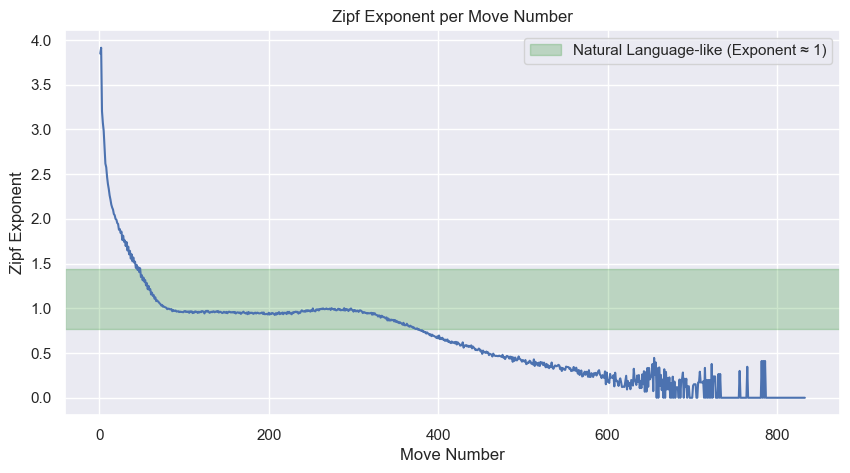

In [41]:
#Plot the Zipf exponents
plt.figure(figsize=(10, 5))
plt.plot(range(1, maxLegths + 1), zipf_exponents, markersize=2)
plt.title("Zipf Exponent per Move Number")
plt.xlabel("Move Number")
plt.ylabel("Zipf Exponent")
plt.axhspan(0.77, 1.44, color='green', alpha=0.2, label='Natural Language-like (Exponent ≈ 1)')
plt.legend()
plt.show()

From the plot, it is evident that the exponent computed using the first N moves of all games (with N between approximately 80 and 300) is very close to one, which suggests it can be approximated to that of a natural language.

#### N-grams analysis

Another interesting analysis to perform in order to answer the question is the n-grams analysis.

N-grams are contiguous sequences of N words that could indicate regularities in languages (words that often appear with the same words).

The analysis to perform now is the following:

`Is the chess language more uniform than a natural language (moves appear frequently near the same moves) or are the two languages types comparable?`

In [42]:
import chess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from typing import List, Tuple
import seaborn as sns
sns.set_theme()
from nlpChess.utils.DatasetLoader import loadConcatenatedDataset, loadConcatenatedShakespeareDataset

Load the data and remove the fifth character (promotions) from the moves

In [44]:
ds = loadConcatenatedDataset()
df = ds.to_pandas()


def removeFifthChar(string):
    if len(string) < 5:
        return string
    return string[:4]

#Apply the function to the 'moves' column
df['moves'] = df['Moves'].apply(removeFifthChar)

Concatanate all moves from all games into a single list

In [45]:
moves = np.concatenate(df['moves'].values)
moves

array(['e2e4', 'g7g6', 'g1f3', ..., 'g8f6', 'c2c4', 'g7g6'], dtype=object)

Load the Shakespear dataset

In [46]:
dsShakespeare = loadConcatenatedShakespeareDataset()
dfShakespeare = dsShakespeare.to_pandas()
dfShakespeare.head()

,Unnamed: 0,Dataline,Play,PlayerLinenumber,ActSceneLine,Player,PlayerLine
0,19217,19218,Antony and Cleopatra,9.0,2.1.33,POMPEY,"How now, Varrius!"
1,99413,99414,Troilus and Cressida,32.0,1.2.66,CRESSIDA,"Ay, if I ever saw him before and knew him."
2,104667,104668,Twelfth Night,86.0,3.4.193,VIOLA,With the same 'havior that your passion bears
3,41989,41990,Henry VIII,41.0,3.2.121,SUFFOLK,"May be, he hears the king"
4,36553,36554,Hamlet,119.0,5.2.312,HAMLET,"Nay, come, again."


Concatenate all lines of all plays.

In [47]:
lines = dfShakespeare['PlayerLine'].tolist()
lines = ' '.join(lines)
lines[:500]

"How now, Varrius! Ay, if I ever saw him before and knew him. With the same 'havior that your passion bears May be, he hears the king Nay, come, again. Nor in a way so chaste, since my desires My lord, Fie on sinful fantasy! I warrant thee. Of ill-shaped fishes, and about his shelves Prithee, do, Jack. So bad an instrument: his name's Parolles. Your franchises, whereon you stood, confined The rest is labour, which is not used for you: Hot, hot, and moist: this hand of yours requires Why might not"

Remove stopwords and punctuation from Shakespear to have better results on n-grams

In [48]:
lines = lines.lower()
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def removeStopwords(text: str) -> str:
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

import string
def removePunctuation(text: str) -> str:
    return text.translate(str.maketrans('', '', string.punctuation))

lines = removeStopwords(lines)
lines = removePunctuation(lines)
lines = lines.split()
lines[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['now',
 'varrius',
 'ay',
 'ever',
 'saw',
 'knew',
 'him',
 'havior',
 'passion',
 'bears']

Let's define a method to compute the most common n-grams in a sequence of tokens.

In [49]:
def most_common_ngrams(moves: List[str], n: int, top_k: int = 10) -> List[Tuple[Tuple[str], int]]:
    ngrams = (tuple(moves[i:i+n]) for i in range(len(moves) - n + 1))
    counter = Counter(ngrams)
    return counter.most_common(top_k), len(moves) - n + 1


Let's try computing and plotting the top 10 4-grams both for chess and Shakespear to compare the two.

In [50]:
top_ngrams_shakespear, _ = most_common_ngrams(lines, 4, 10)
top_ngrams_chess, _ = most_common_ngrams(moves, 4, 10)

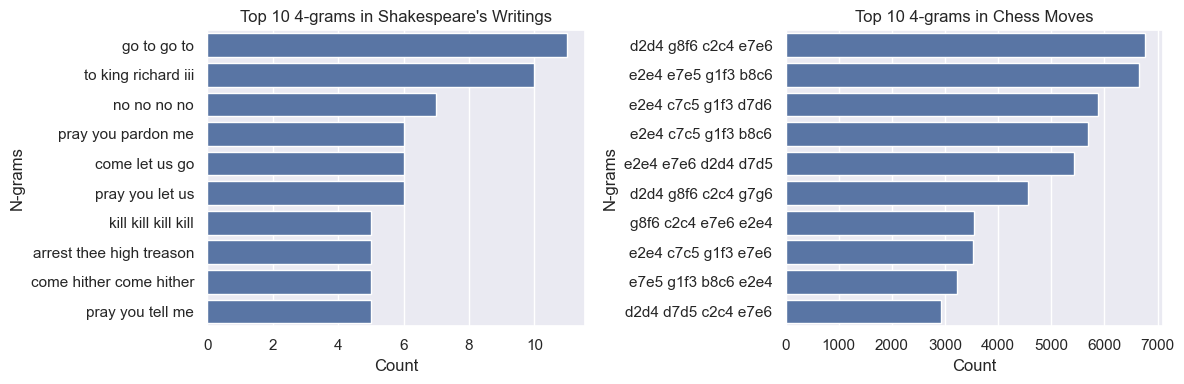

In [51]:
# plot the top 10 ngrams side by side
def plot_top_ngrams_side_by_side(ngrams1, title1, ngrams2, title2):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=False)
    
    ngram_labels1 = [' '.join(ngram) for ngram, _ in ngrams1]
    counts1 = [count for _, count in ngrams1]
    sns.barplot(x=counts1, y=ngram_labels1, ax=axes[0])
    axes[0].set_title(title1)
    axes[0].set_xlabel('Count')
    axes[0].set_ylabel('N-grams')
    
    ngram_labels2 = [' '.join(ngram) for ngram, _ in ngrams2]
    counts2 = [count for _, count in ngrams2]
    sns.barplot(x=counts2, y=ngram_labels2, ax=axes[1])
    axes[1].set_title(title2)
    axes[1].set_xlabel('Count')
    axes[1].set_ylabel('N-grams')
    
    plt.tight_layout()
    plt.show()

plot_top_ngrams_side_by_side(
    top_ngrams_shakespear, "Top 10 4-grams in Shakespeare's Writings",
    top_ngrams_chess, "Top 10 4-grams in Chess Moves"
)

It should be interesting to visualize the n-grams for chess on a checkboard to see if any meaningful patterns or structures emerge. Let's try it.

Top 0 4-gram: ('d2d4', 'g8f6', 'c2c4', 'e7e6'), Count: 6771


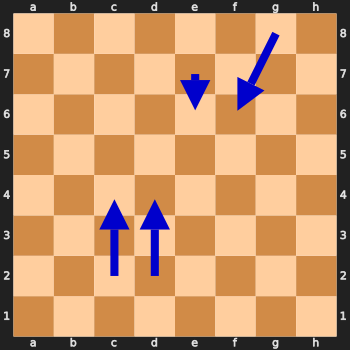

Top 1 4-gram: ('e2e4', 'e7e5', 'g1f3', 'b8c6'), Count: 6652


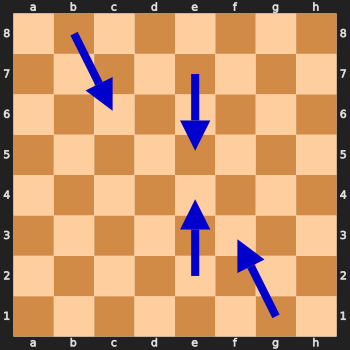

Top 2 4-gram: ('e2e4', 'c7c5', 'g1f3', 'd7d6'), Count: 5879


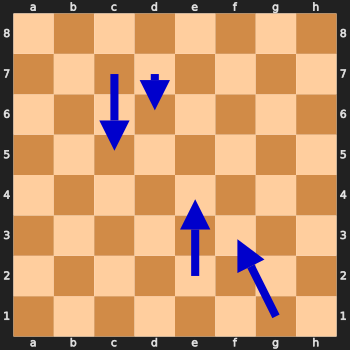

Top 3 4-gram: ('e2e4', 'c7c5', 'g1f3', 'b8c6'), Count: 5695


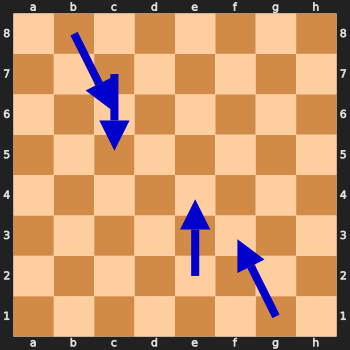

Top 4 4-gram: ('e2e4', 'e7e6', 'd2d4', 'd7d5'), Count: 5434


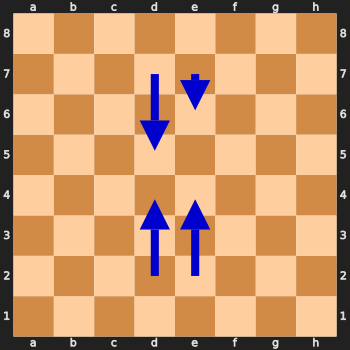

Top 5 4-gram: ('d2d4', 'g8f6', 'c2c4', 'g7g6'), Count: 4568


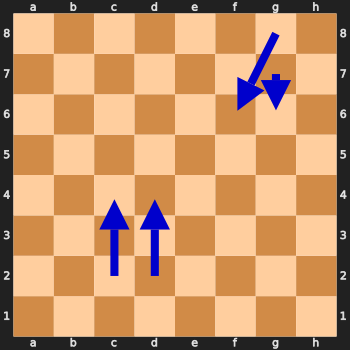

Top 6 4-gram: ('g8f6', 'c2c4', 'e7e6', 'e2e4'), Count: 3537


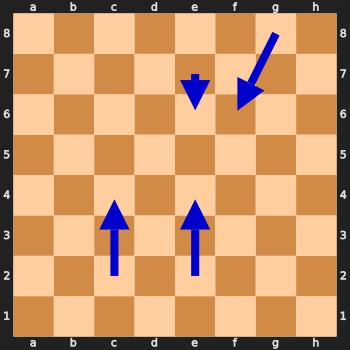

Top 7 4-gram: ('e2e4', 'c7c5', 'g1f3', 'e7e6'), Count: 3530


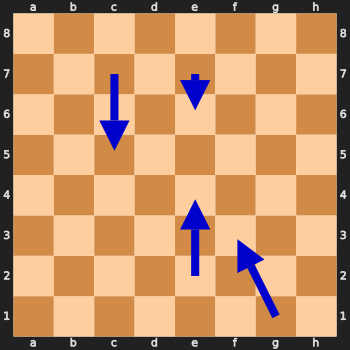

Top 8 4-gram: ('e7e5', 'g1f3', 'b8c6', 'e2e4'), Count: 3230


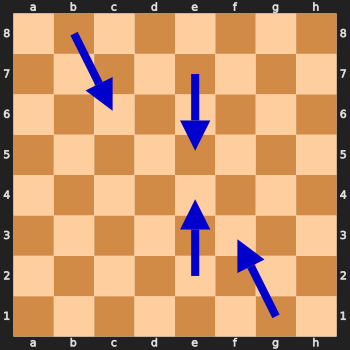

Top 9 4-gram: ('d2d4', 'd7d5', 'c2c4', 'e7e6'), Count: 2918


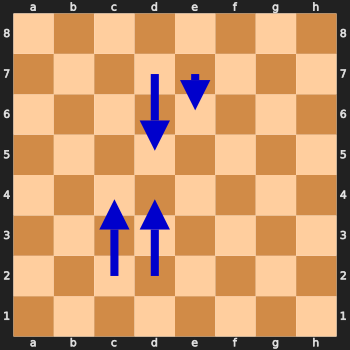

In [52]:
from nlpChess.utils.MovePlotter import MovePlotter

for i, (ngram, count) in enumerate(top_ngrams_chess):
    plotter = MovePlotter(f"Top {i} 4-gram in Chess Moves")
    print(f"Top {i} 4-gram: {ngram}, Count: {count}")
    for move in ngram:
        plotter.addMove(move)
    plotter.plot(justBoard=True)

The structure of these moves together resemble opening structure.

For example the first n-gram plotted is exactly the start of the [Nimzo-Indian Defense](https://www.chess.com/openings/Nimzo-Indian-Defense)

The second one is the [Italian Game](https://www.chess.com/openings/Italian-Game) and so on.

This observation is meaningful, it suggests that the most structured and frequently repeated part of chess games is the opening phase.

It's also evident that the count of n-grams found is much bigger for chess. 

This could indicate that the chess language is more uniform but we have to normalize it taking into account the different lenght of the two dataset and trying it for different Ns.

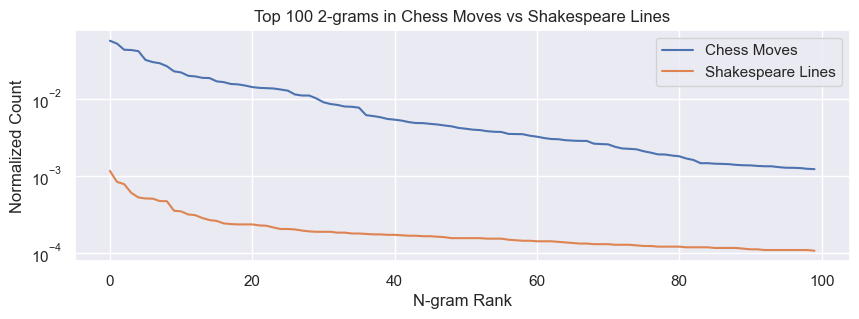

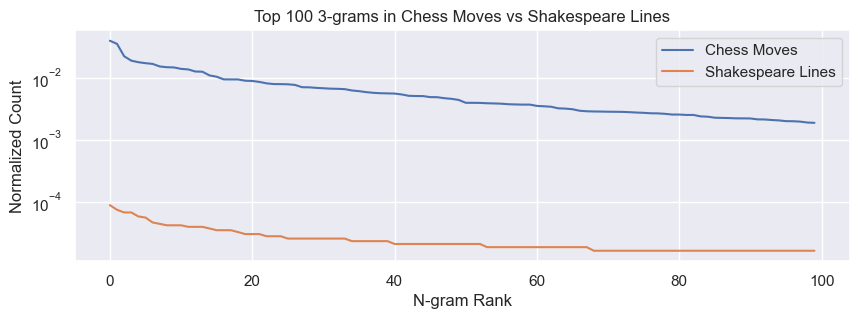

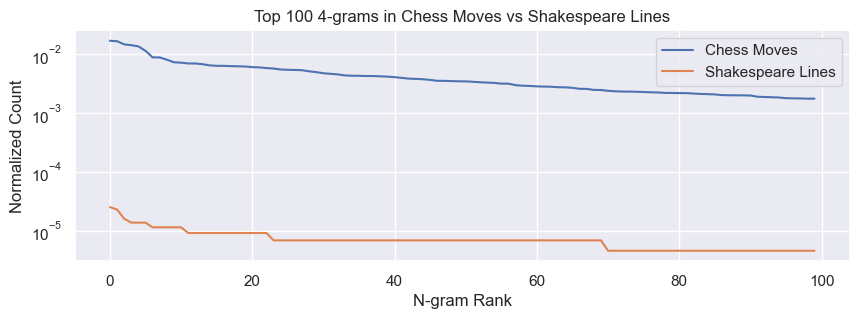

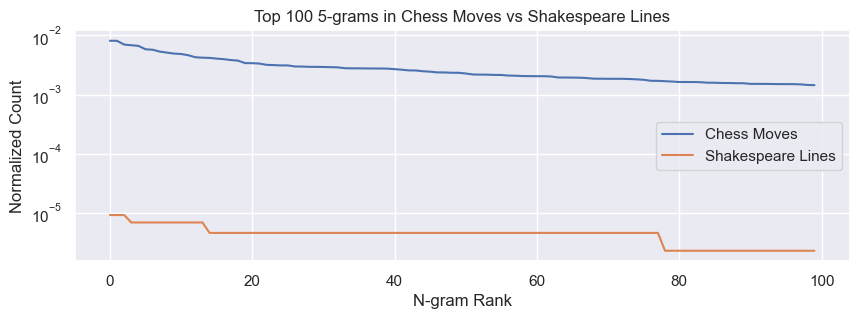

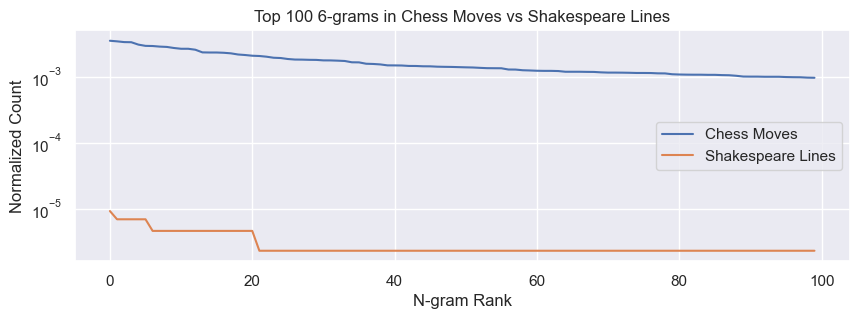

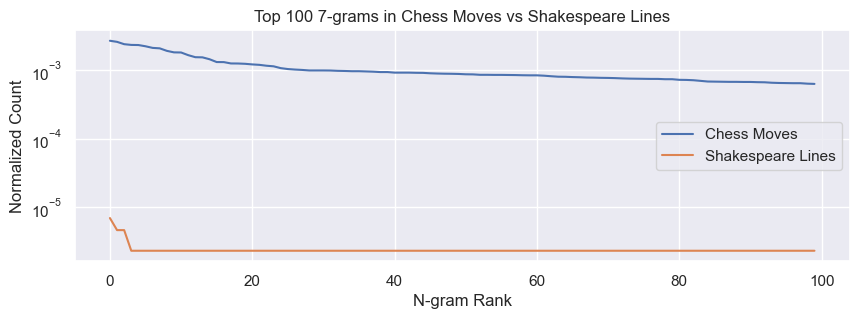

In [53]:
topK = 100

for n in range(2, 8):
    ngramsChess, nNgramsChess = most_common_ngrams(moves, n, topK)
    ngramsShakespear, nNgramsShakespear = most_common_ngrams(lines, n, topK)

    plt.figure(figsize=(10, 3))
    plt.semilogy(range(topK), [count/nNgramsChess for _, count in ngramsChess], label='Chess Moves')
    plt.semilogy(range(topK), [count/nNgramsShakespear for _, count in ngramsShakespear], label='Shakespeare Lines')
    plt.title(f'Top {topK} {n}-grams in Chess Moves vs Shakespeare Lines')
    plt.xlabel('N-gram Rank')
    plt.ylabel('Normalized Count')
    # plt.xticks(range(topK), [f'#{i+1}' for i in range(topK)])
    plt.legend()
    plt.show()

Even normalizing the count of N-grams and plotting the top 100 n-grams it's evident the higher regularity in the chess language with respect to the english one.

Let's now see if some of the famous openings are in the top n-grams (respectively to their lenght).

The most frequent openings are:

In [54]:
famous_openings = {
    "Ruy Lopez (Spanish Opening)": ["e2e4", "e7e5", "g1f3", "b8c6", "f1b5"],
    "Italian Game": ["e2e4", "e7e5", "g1f3", "b8c6", "f1c4"],
    "Sicilian Defense": ["e2e4", "c7c5"],
    "Open Sicilian": ["e2e4", "c7c5", "g1f3", "d7d6", "d2d4", "c5d4", "f3d4"],
    "French Defense": ["e2e4", "e7e6"],
    "Caro-Kann Defense": ["e2e4", "c7c6"],
    "Queen's Gambit": ["d2d4", "d7d5", "c2c4"],
    "King's Indian Defense": ["d2d4", "g8f6", "c2c4", "g7g6"],
    "Slav Defense": ["d2d4", "d7d5", "c2c4", "c7c6"],
    "Scandinavian Defense": ["e2e4", "d7d5"],
    "English Opening": ["c2c4"],
    "King's Gambit": ["e2e4", "e7e5", "f2f4"],
    "Nimzo-Indian Defense": ["d2d4", "g8f6", "c2c4", "e7e6", "b1c3", "f8b4"],
}


Let's check if the n-grams represent famous openings

In [55]:
#check if the openings are in the top 5 ngrams
def check_openings_in_ngrams(openings: dict, ngrams:List[Tuple]) -> List[str]:
    openings_list = []
    for opening, moves in openings.items():
        moves_str = ' '.join(moves)
        for i, (ngram, count) in enumerate(ngrams):
            if moves_str in ' '.join(ngram):
                openings_list.append({"Opening": opening, "Moves": moves_str, "Rank":i, "Count": count})
                break
            
    return openings_list

In [57]:
check_openings_in_ngrams(famous_openings, top_ngrams_chess)

[{'Opening': 'Sicilian Defense',
  'Moves': 'e2e4 c7c5',
  'Rank': 2,
  'Count': 5879},
 {'Opening': 'French Defense', 'Moves': 'e2e4 e7e6', 'Rank': 4, 'Count': 5434},
 {'Opening': "Queen's Gambit",
  'Moves': 'd2d4 d7d5 c2c4',
  'Rank': 9,
  'Count': 2918},
 {'Opening': "King's Indian Defense",
  'Moves': 'd2d4 g8f6 c2c4 g7g6',
  'Rank': 5,
  'Count': 4568},
 {'Opening': 'English Opening', 'Moves': 'c2c4', 'Rank': 0, 'Count': 6771}]

It is possible to see that some of the most famous openings are present in the top n-grams in chess.

Let's visualize it on a plot.

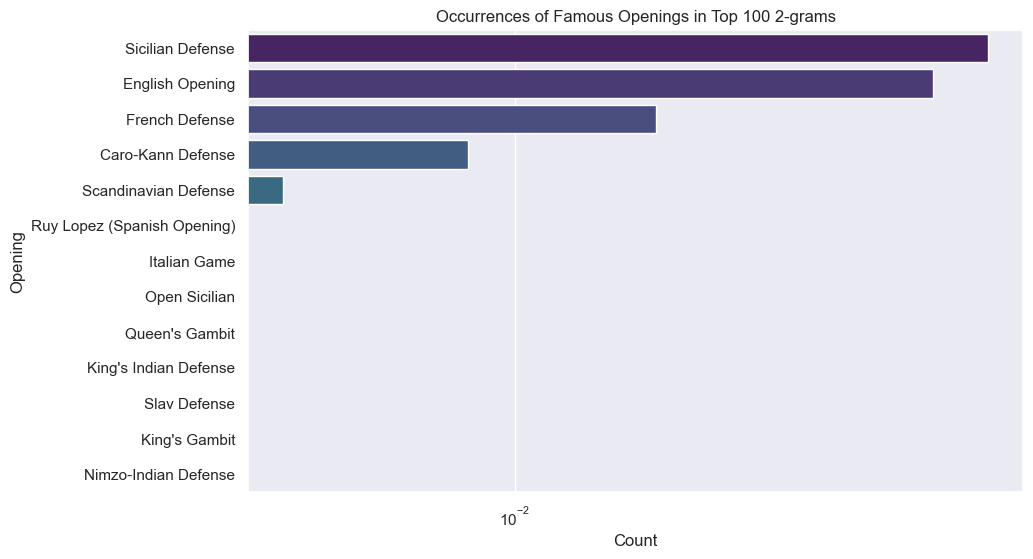

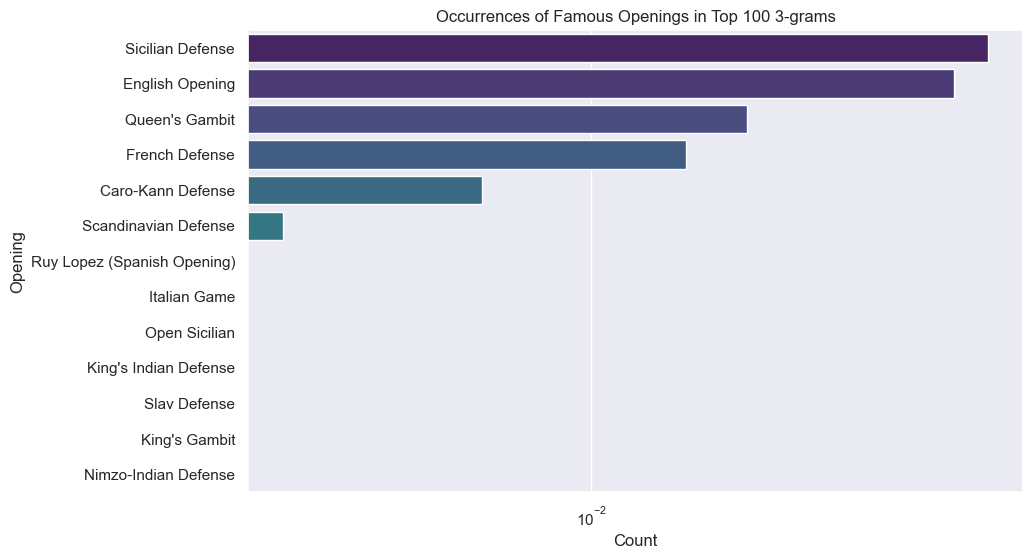

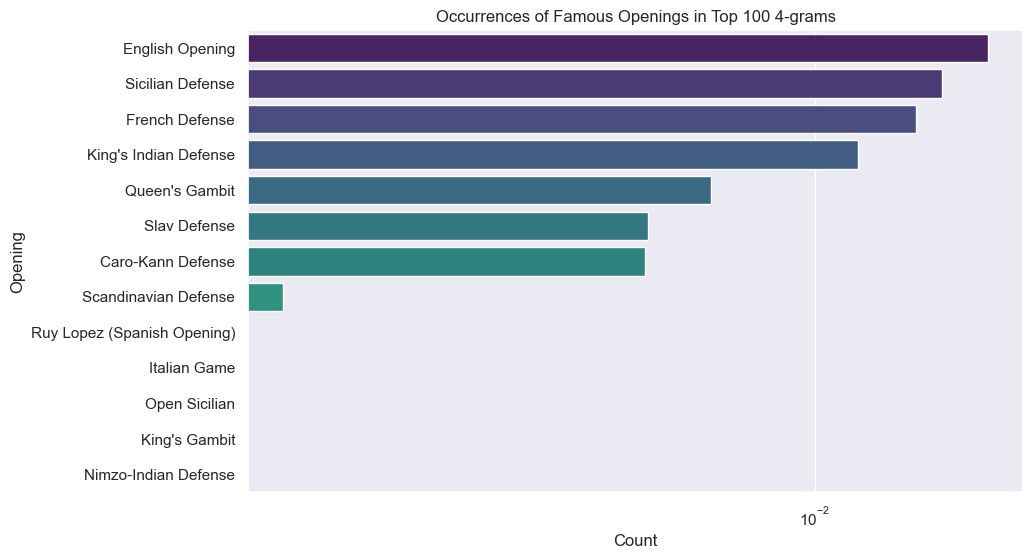

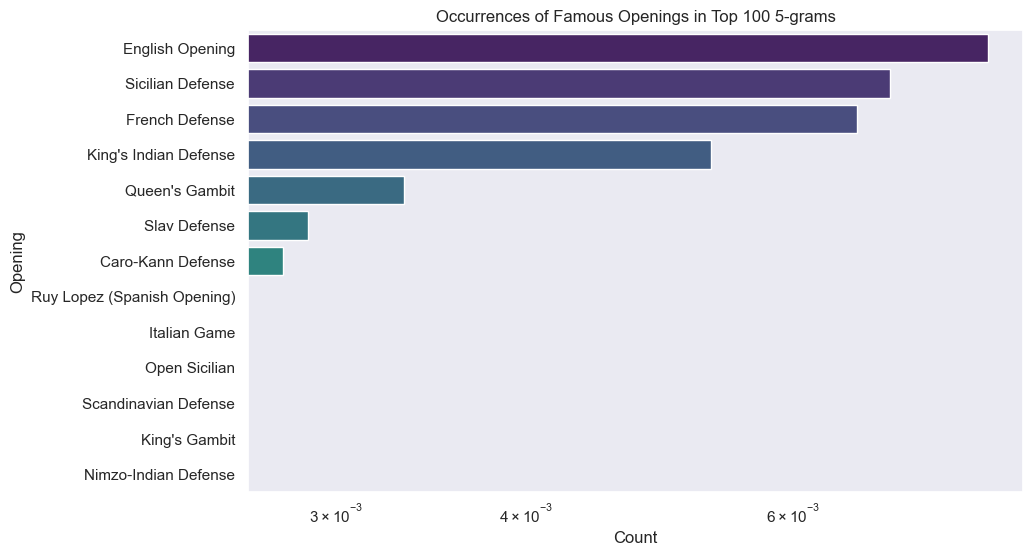

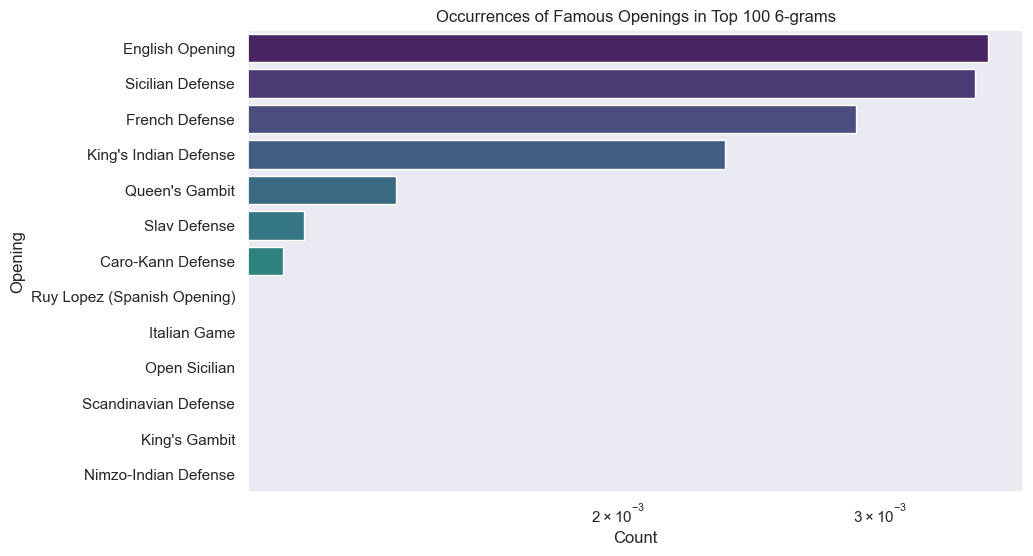

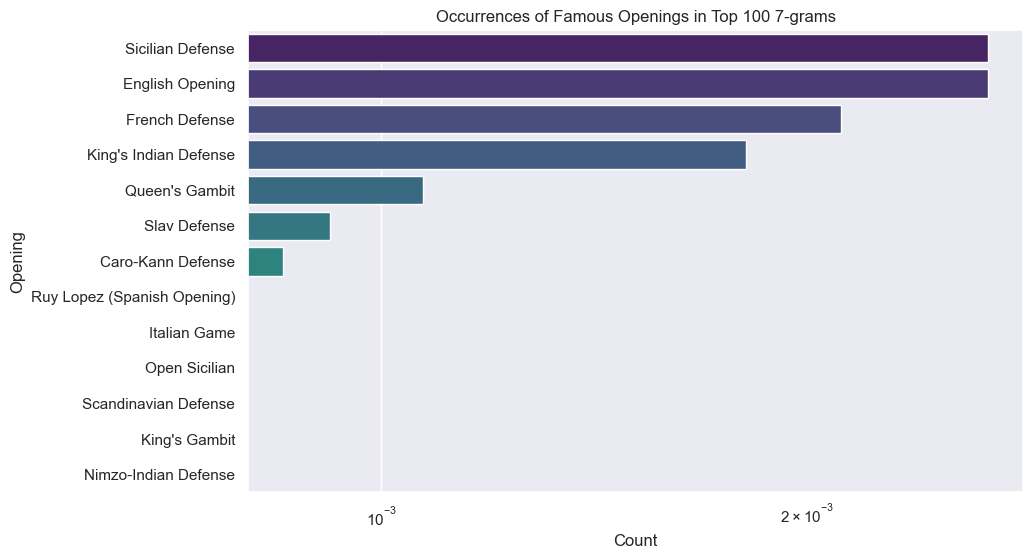

In [58]:
for n in range(2, 8):
    # Plot the openings in ngrams
    ngramsChess, nNgramsChess = most_common_ngrams(moves, n, 100)
    openings_in_ngrams = check_openings_in_ngrams(famous_openings, ngrams=ngramsChess)

    #Compute the total count per opening
    opening_counts = []
    for opening in famous_openings:
        moves_str = ' '.join(famous_openings[opening])
        count = sum(r['Count'] for r in openings_in_ngrams if opening == r['Opening']) / nNgramsChess
        opening_counts.append((opening, count))

    # Convert to DataFrame for plotting
    openings_count_df = pd.DataFrame(opening_counts, columns=['Opening', 'Count']).sort_values('Count', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Count', y='Opening', data=openings_count_df, hue='Opening', palette='viridis', legend=False)
    plt.title(f'Occurrences of Famous Openings in Top 100 {n}-grams')
    plt.xlabel('Count')
    plt.ylabel('Opening')
    plt.xscale('log')
    plt.show()


The plots are quiet interesting because they identify a lot of different openings in the top n-grams.


Obviously the fact that English Opening is at the top of almost every plot is also given by the fact that it consists of just one move, but it is also interesting to see that sometimes the Sicilian Defence is more frequent than English Opening even if it's longer.

## Can be NLP model be used for moves generation?
Utilizing NLP methods on GPT2 before and after fineTuning upon 90k matches

In [10]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import torch
import os

#Standard GPT2: Tokenizer and model

tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


model = GPT2LMHeadModel.from_pretrained("gpt2", trust_remote_code=True)
model.eval()


# Fine-tuned GPT2: Tokenizer1 and model1
model_path = "../ChessBOT_GPT2/Model90K/model" #Modify as soon the model made it to HuggingFace
tokenizer1 = GPT2Tokenizer.from_pretrained(model_path,use_safetensors=True)
if tokenizer1.pad_token is None:
    tokenizer1.pad_token = tokenizer1.eos_token

model1 = GPT2LMHeadModel.from_pretrained(model_path,use_safetensors=True,trust_remote_code=True)
model1.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

Standard function for generation of text with a LLM given a prompt

In [11]:
def generate_text(model,tokenizer,prompt, max_new_tokens=100, temperature=0.7, top_k=50, top_p=0.95):
    inputs = tokenizer(prompt, return_tensors="pt", padding=True)
    prompt_length = len(inputs["input_ids"][0])
    
    with torch.no_grad():
        outputs = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],  
            max_length=prompt_length + max_new_tokens,
            temperature=temperature,
            top_k=top_k,
            top_p=top_p,
            do_sample=True,
            pad_token_id=tokenizer.eos_token_id  
        )
    
    generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    new_text = generated_text[len(tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True)):]
    
    return new_text.strip()

Function to display the board given the history of the match

In [12]:
import chess
## if starting_fen is None, the board will be initialized to the starting position 
def get_fen_from_uci_sequence(uci_sequence, starting_fen=None):

    
    if starting_fen:
        board = chess.Board(starting_fen)
    else:
        board = chess.Board()  
    
    moves = uci_sequence.strip().split()
    
    for move_str in moves:
        
        try:
            move = chess.Move.from_uci(move_str)
            
            if move in board.legal_moves:
                board.push(move)

            else:
                print(f"Moves {move_str} not legal!")
                print("Moves sequence was interrupted.")
                break
        except ValueError:
            print(f"Moves {move_str} not in UCI format!")
            print("Moves sequence was interrupted.")
            break
    
    # Stampa la scacchiera nello stato attuale
    print("\nState of the board:")
    print(board)
    
    # Ritorna la FEN finale
    final_fen = board.fen()
    print(f"\nFEN: {final_fen}")
    
    return final_fen, board

Selection and visualization of the Hystory of the game from the start

In [13]:
movesHistory="c2c4 c7c5 b1a3 g8f6 d2d3 d7d6 a3b5 g7g6 c1h6 f8g7 h6g7 c8g4 b5d4"

FEN,board=get_fen_from_uci_sequence(movesHistory)


State of the board:
r n . q k . . r
p p . . p p B p
. . . p . n p .
. . p . . . . .
. . P N . . b .
. . . P . . . .
P P . . P P P P
R . . Q K B N R

FEN: rn1qk2r/pp2ppBp/3p1np1/2p5/2PN2b1/3P4/PP2PPPP/R2QKBNR b KQkq - 2 7


#### ZeroShot

The prompt used for this task

In [14]:
prompt1 = f"""You are a chess assistant. Given a sequence of UCI moves, suggest two reasonable next moves for the side to play.
Remeber the first moves of the sequence I gave is played by white, the second by black and so on.

Moves so far:
{movesHistory}

Your suggestions:"""

stdGPT2Response=generate_text(model,tokenizer,prompt1,50)
print(f"Standard GPT2 response:\n{stdGPT2Response}\n")

fineTuneGPT2Response=generate_text(model1,tokenizer1,prompt1,50)
print(f"Fine-tuned GPT2 response:\n{fineTuneGPT2Response}\n")

The part of the prompt asking for 2 possibile moves got completely ignored from both the models, the finetuned one simply start try playing for both the player.
The slice of the prompt: "Remeber the first moves of the sequence I gave is played by white, the second by black and so on" is crucial for the second model otherwise the response often start with a moves of the wrong player

The difference between the two model is clear stdGPT2 doesn't get what is a UCI format by itself and as a single move show some random char, on the other hand the other model seem not to understand anymore the request of having two suggestion nor having a suggestion fot the next move as it start simply to play.

Sometimes the finetuned model start the response with a single char followed by a space and then a sequence of UCI moves, if the single CHAR is ignored the following move is usually valid



Here a longer moves History to see if the model can handle it

In [15]:
movesHistoryLong="d2d4 d7d5 c2c4 e7e6 b1c3 c7c5 c4d5 e6d5 g1f3 g8f6 c1g5 c5d4 f3d4 f8e7 e2e3 b8c6 f1e2 e8g8 e1g1 a7a6 a1c1 f8e8 e2f3 c8e6 c3e2 c6e5 e2f4 e5f3 d1f3 e6g4 f3g3 d8d7 g5f6 e7f6 h2h3 g4f5 d4f5 d7f5 c1c5 a8d8 f1d1 f6b2 c5d5 d8d5 f4d5 f5c2 d5e7 g8f8 d1d7 c2c5 e7d5 b2e5 f2f4 e5d6 g3g5 e8e3 d5e3 c5e3 g1f1 e3d3 f1f2 d3d4 f2f3 d4d1 f3f2 d1d2 f2f1 d2d1 f1f2 d1d2 f2f1 d2d3 f1f2 d3d2 f2f1 d2d3 f1f2 d3d2 f2f1 d2d3 f1f2 d3d4 f2f3 d4d1 f3f2"

promptL = f"""You are a chess assistant. Given a sequence of UCI moves, suggest two reasonable next moves for the side to play.
Remeber the first moves of the sequence I gave is played by white, the second by black and so on.

Moves so far:
{movesHistoryLong}

Your suggestions:"""

FEN,board=get_fen_from_uci_sequence(movesHistoryLong)


State of the board:
. . . . . k . .
. p . R . p p p
p . . b . . . .
. . . . . . Q .
. . . . . P . .
. . . . . . . P
P . . . . K P .
. . . q . . . .

FEN: 5k2/1p1R1ppp/p2b4/6Q1/5P2/7P/P4KP1/3q4 b - - 27 43


In [16]:
stdGPT2Response=generate_text(model,tokenizer,promptL,50)
print(f"Standard GPT2 response:\n{stdGPT2Response}\n")

fineTuneGPT2Response=generate_text(model1,tokenizer1,promptL,50)
print(f"Fine-tuned GPT2 response:\n{fineTuneGPT2Response}\n")

Standard GPT2 response:
Move the sequence from left to right. I recommend this:

d3d4 d5f6 e6e4 e5f3 e4e6 e3d4 f6d4 f8e6 e2

Fine-tuned GPT2 response:
7 e3d3 f1 f1f2 d7f3 g5d3 f2 d3d2 f2f2 d1f2 d3d2 f3d2 f1 f3d2 f2 f



Already with an history not huge compared to the one in the dataset also the fineTuned model start messing up proposing unlegal moves,sometimes moving a piece like it was another, and also start showing "UCI moves" of 2 char; that probably caused by the limited context GPT2 can handle, stdGPT2 sometimes print some move in the response but not in the expected format and not even valid moves

#### FewShot

The prompt used for this other task contain 2 examples of wanted response

In [17]:
prompt2=f"""
You are a chess assistant. Given a sequence of UCI moves, suggest two plausible next moves for the player to play.
Remeber the first moves of the sequence I gave is played by white, the second by black and so on.
    
Example 1  
Moves so far:  
d2d4 g8f6 c2c4 e7e6 g1f3 d7d5 b1c3 f8e7 c1g5 h7h6  
Suggestions: g5h4 e2e3  

Example 2  
Moves so far:  
e2e4 e7e5 g1f3 b8c6 f1b5 a7a6 b5a4 g8f6 e1g1 f8e7 f1e1 b7b5 a4b3  
Suggestions: c2c3 f3g5  

Now it's your turn:

Moves so far:  
{movesHistory}  
Suggestions: """

In [18]:
stdGPT2Response=generate_text(model,tokenizer,prompt2,50)
print(f"Standard GPT2 response:\n{stdGPT2Response}\n")

fineTuneGPT2Response=generate_text(model1,tokenizer1,prompt2,50)
print(f"Fine-tuned GPT2 response:\n{fineTuneGPT2Response}\n")

Standard GPT2 response:
Moves so far:  

e2e4 e7e5 c2c4 d2d3 d7d6 a3b5 g8f6 e1g1 f8e7 f1

Fine-tuned GPT2 response:
4d3 g4f3 d6d5 e4d5 d5e6 d3e2 e8f8 g5h7 e5f3 h7g8 f6e4 f3e3 e6d



The problems seen with GPT2 stay the same, also the thing it say are not coherent with the movesHistory: "c2c4 c7c5 b1a3 g8f6 d2d3 d7d6 a3b5 g7g6 c1h6 f8g7 h6g7 c8g4 b5d4"

The fineTuned model here doesn't improve in any way and more often start the sequence with a 3 char which doesn't represent any moves in the UCI format

#### FineTuned ZeroShot evaluation
We'd like to have a sometimes of evaluation regarding if the fineTuned model is able to generate valid moves consistently, so instead os std measurament we'll use legal rate which consist in tot_question/n_legal_prediction

In [20]:
import chess
import re
import os

In [21]:
def evaluate_legal_moves_from_file(filename, model, tokenizer, num_samples=10000, temperature=0.7, verbose=True):
    """
    Calculates statistics on legal move predictions from the model.
    
    Args:
        filename (str): Path to the file with move sequences, one per line
        model: Language model to evaluate
        tokenizer: Tokenizer associated with the model
        num_samples (int): Maximum number of samples to evaluate
        temperature (float): Temperature to use for generation
        verbose (bool): If True, prints details during execution
    
    Returns:
        dict: Dictionary with prediction statistics
    """
    if not os.path.exists(filename):
        raise FileNotFoundError(f"File {filename} not found")
    
    # Read move sequences from file
    with open(filename, 'r') as f:
        move_sequences = [line.strip() for line in f if line.strip()]
    
    # Limit the number of samples if necessary
    if num_samples and num_samples < len(move_sequences):
        move_sequences = move_sequences[:num_samples]
    
    # Statistics
    total_predictions = 0
    legal_moves = 0
    illegal_moves = 0
    invalid_format = 0
    stats_by_length = {}
    
    # Pattern to extract the first UCI move from the model's response
    move_pattern = r'([a-h][1-8][a-h][1-8][qrbnkQRBNK]?)'
    
    if verbose:
        print(f"Evaluating {len(move_sequences)} move sequences...")
    
    # Process each sequence
    for i, sequence in enumerate(move_sequences):
        if verbose and i % 10 == 0:
            print(f"Processing sequence {i+1}/{len(move_sequences)}...")
        
        # Set up the chessboard with the sequence moves
        board = chess.Board()
        moves = sequence.split()
        
        # Apply all moves to the board
        valid_sequence = True
        for move_str in moves:
            try:
                move = chess.Move.from_uci(move_str)
                if move in board.legal_moves:
                    board.push(move)
                else:
                    valid_sequence = False
                    if verbose:
                        print(f"Invalid move in sequence {i+1}: {move_str}")
                    break
            except ValueError:
                valid_sequence = False
                if verbose:
                    print(f"Invalid move format in sequence {i+1}: {move_str}")
                break
        
        # Skip invalid sequences
        if not valid_sequence:
            continue
        
        # Generate the prompt for the model
        prompt = f"""You are a chess assistant. Given a sequence of UCI moves, suggest two reasonable next moves for the side to play.
        Remember the first moves of the sequence I gave is played by white, the second by black and so on.

        Moves so far:
        {sequence}

        Your suggestions:"""
        
        # Generate the prediction
        prediction = generate_text(model, tokenizer, prompt, max_new_tokens=10, temperature=temperature)
        
        # Extract the first move in UCI format from the prediction
        match = re.search(move_pattern, prediction)
        predicted_move = match.group(1) if match else None
        
        # Track statistics by sequence length
        seq_length = len(moves)
        if seq_length not in stats_by_length:
            stats_by_length[seq_length] = {
                'total': 0, 'legal': 0, 'illegal': 0, 'invalid': 0
            }
        
        # Check if the predicted move is valid
        total_predictions += 1
        stats_by_length[seq_length]['total'] += 1
        
        if predicted_move is None:
            invalid_format += 1
            stats_by_length[seq_length]['invalid'] += 1
            if verbose:
                print(f"Prediction without valid UCI format: '{prediction}'")
        else:
            try:
                move = chess.Move.from_uci(predicted_move)
                if move in board.legal_moves:
                    legal_moves += 1
                    stats_by_length[seq_length]['legal'] += 1
                    if verbose:
                        print(f"Legal move predicted: {predicted_move}")
                else:
                    illegal_moves += 1
                    stats_by_length[seq_length]['illegal'] += 1
                    if verbose:
                        print(f"Illegal move predicted: {predicted_move}")
            except ValueError:
                invalid_format += 1
                stats_by_length[seq_length]['invalid'] += 1
                if verbose:
                    print(f"Invalid predicted move format: {predicted_move}")
    
    # Calculate final statistics
    legal_rate = legal_moves / total_predictions * 100 if total_predictions > 0 else 0
    illegal_rate = illegal_moves / total_predictions * 100 if total_predictions > 0 else 0
    invalid_rate = invalid_format / total_predictions * 100 if total_predictions > 0 else 0
    
    # Results
    results = {
        'total_predictions': total_predictions,
        'legal_moves': legal_moves,
        'illegal_moves': illegal_moves,
        'invalid_format': invalid_format,
        'legal_rate': legal_rate,
        'illegal_rate': illegal_rate,
        'invalid_rate': invalid_rate,
        'stats_by_length': stats_by_length
    }
    
    # Print statistics report
    print("\n--- PREDICTION STATISTICS ---")
    print(f"Total predictions: {total_predictions}")
    print(f"Legal moves: {legal_moves} ({legal_rate:.2f}%)")
    print(f"Illegal moves: {illegal_moves} ({illegal_rate:.2f}%)")
    print(f"Invalid format: {invalid_format} ({invalid_rate:.2f}%)")
        
    print("\n--- DETAIL BY SEQUENCE LENGTH ---")
    for length, stats in sorted(stats_by_length.items()):
        if stats['total'] > 0:
            legal_pct = stats['legal'] / stats['total'] * 100
            print(f"Length {length}: {stats['legal']}/{stats['total']} legal moves ({legal_pct:.2f}%)")
    
    return results

This function has been used on a file "testing_sequence.txt" which has been generated from 10k matches not used in the fineTuning of the model, it contain the first moves for each games: the lenght of each sequence has been randomically chosen by random.randint between 1 and 20

The computation took like 2h so here the result will be report trough a reading of a .txt file were the evaluation was saved

In [ ]:

results = evaluate_legal_moves_from_file(
    "../ChessBOT_GPT2/testing_sequences.txt", 
    model1,                 
    tokenizer1,             
    temperature=0.7,      
    num_samples=10000, #The 10k squences are in the file were not used in the tuning
    verbose=False         
)

print(f"Percentage of legal moves: {results['legal_rate']:.2f}%")

In [ ]:
with open("legalRate.txt", 'w') as f:
        # Write overall statistics
        f.write("=== PREDICTION STATISTICS ===\n")
        f.write(f"Total predictions: {results['total_predictions']}\n")
        f.write(f"Legal moves: {results['legal_moves']} ({results['legal_rate']:.2f}%)\n")
        f.write(f"Illegal moves: {results['illegal_moves']} ({results['illegal_rate']:.2f}%)\n")
        f.write(f"Invalid format: {results['invalid_format']} ({results['invalid_rate']:.2f}%)\n\n")
        
        # Write statistics by sequence length
        f.write("=== DETAIL BY SEQUENCE LENGTH ===\n")
        for length, stats in sorted(results['stats_by_length'].items()):
            if stats['total'] > 0:
                legal_pct = stats['legal'] / stats['total'] * 100
                f.write(f"Length {length}: {stats['legal']}/{stats['total']} legal moves ({legal_pct:.2f}%)\n")
        
        # Write timestamp
        import datetime
        f.write(f"\nResults generated on: {datetime.datetime.now()}")

In [23]:
    filename="../ChessBOT_GPT2/legalRate.txt"
    try:
        with open(filename, 'r') as f:
            content = f.read()
            print(content)
    except FileNotFoundError:
        print(f"File '{filename}' non trovato.")
    except Exception as e:
        print(f"Errore durante la lettura del file: {e}")



=== PREDICTION STATISTICS ===
Total predictions: 10000
Legal moves: 3274 (32.74%)
Illegal moves: 6726 (67.26%)
Invalid format: 0 (0.00%)

=== DETAIL BY SEQUENCE LENGTH ===
Length 1: 261/462 legal moves (56.49%)
Length 2: 143/504 legal moves (28.37%)
Length 3: 180/506 legal moves (35.57%)
Length 4: 182/507 legal moves (35.90%)
Length 5: 160/557 legal moves (28.73%)
Length 6: 123/491 legal moves (25.05%)
Length 7: 137/503 legal moves (27.24%)
Length 8: 113/469 legal moves (24.09%)
Length 9: 199/498 legal moves (39.96%)
Length 10: 105/472 legal moves (22.25%)
Length 11: 190/493 legal moves (38.54%)
Length 12: 101/484 legal moves (20.87%)
Length 13: 237/463 legal moves (51.19%)
Length 14: 114/498 legal moves (22.89%)
Length 15: 223/494 legal moves (45.14%)
Length 16: 132/520 legal moves (25.38%)
Length 17: 199/532 legal moves (37.41%)
Length 18: 137/505 legal moves (27.13%)
Length 19: 214/513 legal moves (41.72%)
Length 20: 124/529 legal moves (23.44%)

Results generated on: 2025-05-23 19:

It's not the best possible outcome, but having the bot generate multiple responses and then playing the first legal one makes it viable.

#### ChessBot